In [1]:
import os
import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
# Download S&P History Stock Data
sp_data = yf.download(tickers="^GSPC")
sp_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0


In [6]:
# Shift features 
sp_data['prev_day_close'] = sp_data.Close.shift(1)
sp_data['prev_day_open'] = sp_data.Open.shift(1)
sp_data['prev_day_adj_close'] = sp_data['Adj Close'].shift(1)
sp_data['prev_day_high'] = sp_data.High.shift(1)
sp_data['prev_day_Low'] = sp_data.Low.shift(1)
sp_data['prev_day_volume'] = sp_data.Volume.shift(1)

# Target Variable to predict if the stock went up
sp_data["stock_went_up"] = sp_data.Close > sp_data.prev_day_close

In [7]:
sp_data.head()

,Open,High,Low,Close,Adj Close,Volume,prev_day_close,prev_day_open,prev_day_adj_close,prev_day_high,prev_day_Low,prev_day_volume,stock_went_up
Date,,,,,,,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0,NaN,NaN,NaN,NaN,NaN,NaN,False
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0,17.660000,17.660000,17.660000,17.660000,17.660000,0.0,True
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0,17.760000,17.760000,17.760000,17.760000,17.760000,0.0,False
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0,17.719999,17.719999,17.719999,17.719999,17.719999,0.0,False
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0,17.549999,17.549999,17.549999,17.549999,17.549999,0.0,True


In [8]:
sp_data.stock_went_up.value_counts().rename(index={True: "Stock Went Up",False:"Stock Went Down"})

stock_went_up
Stock Went Up      12709
Stock Went Down    11559
Name: count, dtype: int64

In [8]:
# 52% of the time the S&P went up all time
# Any machine learning model should perform better than 52%
sp_data.stock_went_up.value_counts(normalize=True) * 100

stock_went_up
True     52.367413
False    47.632587
Name: proportion, dtype: float64

<Axes: xlabel='Date', ylabel='Close'>

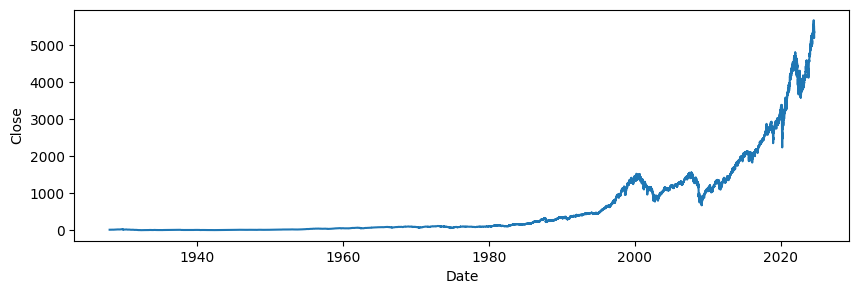

In [11]:
fig, axes = plt.subplots(figsize=(10,3))
sns.lineplot(data=sp_data, x="Date",y="Close")

### Baseline Model

In [12]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler

In [13]:
sp_data.dropna(inplace=True)

In [15]:
X = sp_data[['prev_day_close','prev_day_open', 'prev_day_adj_close', 
             'prev_day_high', 'prev_day_Low','prev_day_volume']]
y = sp_data.stock_went_up

In [16]:
# Standardize Variables
standardizer = StandardScaler()
scaled_X = standardizer.fit_transform(X)

In [17]:
# Split data without shuffling to keep time dependency
X_train, X_test, y_train, y_test = train_test_split(scaled_X,y,test_size=.30,shuffle=False)

In [20]:
logistic_model = LogisticRegression(penalty="l2",max_iter=10000, random_state=29)
logistic_model.fit(X_train,y_train)

LogisticRegression(max_iter=10000, random_state=29)

In [21]:
# Logistic Regression Coefficients
dict(zip(X.columns,logistic_model.coef_.squeeze()))

{'prev_day_close': 0.06167704105391225,
 'prev_day_open': 0.08316591093877103,
 'prev_day_adj_close': 0.06167704105391225,
 'prev_day_high': 0.06027742423447103,
 'prev_day_Low': 0.06014833720076521,
 'prev_day_volume': -0.04960411180871608}

In [22]:
# Use fitted model for prediction
pred_y = logistic_model.predict(X_test)
print(classification_report(y_true=y_test,y_pred=pred_y))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      3375
        True       0.54      1.00      0.70      3906

    accuracy                           0.54      7281
   macro avg       0.27      0.50      0.35      7281
weighted avg       0.29      0.54      0.37      7281



In [ ]:
# Accuracy of 54% and recall of 100% tells me that 
# the model didn't learn anything. Simply predicts
# true every time

In [23]:
forest_model = RandomForestClassifier(random_state=29)
forest_model.fit(X_train,y_train)

RandomForestClassifier(random_state=29)

In [24]:
dict(zip(X.columns,forest_model.feature_importances_))

{'prev_day_close': 0.16775154850475407,
 'prev_day_open': 0.10750704634773153,
 'prev_day_adj_close': 0.16801877771076348,
 'prev_day_high': 0.17961880270032382,
 'prev_day_Low': 0.1801252022565816,
 'prev_day_volume': 0.1969786224798456}

In [25]:
pred_y = forest_model.predict(X_test)
print(classification_report(y_true=y_test,y_pred=pred_y))

              precision    recall  f1-score   support

       False       0.43      0.01      0.01      3375
        True       0.54      0.99      0.70      3906

    accuracy                           0.54      7281
   macro avg       0.48      0.50      0.36      7281
weighted avg       0.49      0.54      0.38      7281



In [ ]:
# Same for Random Forest

### Real Try

In [26]:
# Redownload Data
sp_data = yf.download(tickers="^GSPC")

[*********************100%%**********************]  1 of 1 completed


In [27]:
# Create a daily return column
sp_data['day_return'] = (sp_data['Close'] - sp_data['Open']) / sp_data['Open']

In [28]:
# Some opening prices are 0
# https://stackoverflow.com/questions/69031195/what-happened-to-the-opening-prices-of-the-sp-500-from-1962-to-1982
sp_data[np.isinf(sp_data.day_return)].head()

,Open,High,Low,Close,Adj Close,Volume,day_return
Date,,,,,,,
1962-01-02,0.0,71.959999,70.709999,70.959999,70.959999,3120000,inf
1962-01-03,0.0,71.480003,70.379997,71.129997,71.129997,3590000,inf
1962-01-04,0.0,71.620003,70.449997,70.639999,70.639999,4450000,inf
1962-01-05,0.0,70.839996,69.349998,69.660004,69.660004,4630000,inf
1962-01-08,0.0,69.839996,68.169998,69.120003,69.120003,4620000,inf


In [29]:
# Remove Infinite Values
sp_data = sp_data[~np.isinf(sp_data.day_return)].copy()

In [30]:
sp_data.head()

,Open,High,Low,Close,Adj Close,Volume,day_return
Date,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0,0.0
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0,0.0
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0,0.0
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0,0.0
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0,0.0


In [31]:
# Create a weekly return and monthly return column
weekly_return = sp_data['Close'].resample('W-FRI').ffill().pct_change()
monthly_return = sp_data['Close'].resample('ME').ffill().pct_change()

weekly_return = weekly_return.dropna()
monthly_return = monthly_return.dropna()

sp_data['weekly_return'] = weekly_return.reindex(sp_data.index, method='ffill')
sp_data['monthly_return'] = monthly_return.reindex(sp_data.index, method='ffill')

In [32]:
# Move the Date from index to column to be manipulated
sp_data = sp_data.reset_index()

In [33]:
week_day_dict = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: "Friday",
    5: 'Saturday',
    6: "Sunday"
}

In [34]:
# Date feature engineering
sp_data['day_of_week'] = sp_data['Date'].dt.weekday.map(week_day_dict)
sp_data['month'] = sp_data['Date'].dt.month_name()
sp_data['quarter'] = sp_data['Date'].dt.quarter

In [35]:
def get_season(month_num):
    if month_num in [12, 1, 2]:
        return 'Winter'
    elif month_num in [3, 4, 5]:
        return 'Spring'
    elif month_num in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

In [36]:
sp_data['season'] = sp_data['Date'].dt.month.apply(get_season)

In [37]:
import holidays

In [38]:
nyse_holidays = holidays.financial_holidays("NYSE")
us_holidays = holidays.country_holidays('US')

In [39]:
def personal_get_us_holiday(date):
    res = us_holidays.get(date)
    if res:
        return res
    else:
        return "Not a Holiday"
def personal_get_financial_holiday(date):
    res = nyse_holidays.get(date)
    if res:
        return res
    else:
        return "Not a Holiday"

In [40]:
# Holiday Feature Engineering
sp_data['us_holiday'] = sp_data['Date'].apply(lambda x: personal_get_us_holiday(x))
sp_data['financial_holiday'] = sp_data['Date'].apply(lambda x: personal_get_financial_holiday(x))

In [42]:
sp_data['us_holiday'].value_counts()

us_holiday
Not a Holiday                                      19056
Columbus Day                                          48
Veterans Day                                          37
Veterans Day (observed)                               14
Martin Luther King Jr. Day                            12
New Year's Day (observed)                             10
Thanksgiving                                           5
Independence Day (observed)                            4
Christmas Day (observed)                               3
Armistice Day (observed)                               3
Juneteenth National Independence Day (observed)        1
Name: count, dtype: int64

In [41]:
sp_data['financial_holiday'].value_counts()

financial_holiday
Not a Holiday                       19135
Flag Day                               18
Flag Day (observed)                     8
Thanksgiving Day                        5
Washington's Birthday (observed)        5
Memorial Day (observed)                 5
Columbus Day (observed)                 4
Independence Day (observed)             4
Christmas Day (observed)                3
Lincoln's Birthday (observed)           3
Veteran's Day (observed)                3
Name: count, dtype: int64

In [43]:
# Reset the Index to the date
sp_data = sp_data.set_index("Date")

In [44]:
# Shift Variables
sp_data['prev_day_close'] = sp_data.Close.shift(1)
sp_data['prev_day_open'] = sp_data.Open.shift(1)
sp_data['prev_day_adj_close'] = sp_data['Adj Close'].shift(1)
sp_data['prev_day_high'] = sp_data.High.shift(1)
sp_data['prev_day_Low'] = sp_data.Low.shift(1)
sp_data['prev_day_volume'] = sp_data.Volume.shift(1)
sp_data['prev_day_return'] = sp_data.day_return.shift(1)
sp_data["stock_went_up"] = sp_data.Close > sp_data.prev_day_close

In [45]:
# Create modeling dataframe
modeling_data = sp_data.dropna()

In [46]:
X_vars = ['prev_day_return','weekly_return', 'monthly_return', 
          'day_of_week', 'month', 'quarter','season', 
          'us_holiday', 'financial_holiday', 'prev_day_close',
          'prev_day_open', 'prev_day_adj_close', 'prev_day_high', 
          'prev_day_Low','prev_day_volume']
y_var = "stock_went_up"
numeric_vars = ['prev_day_return','weekly_return', 'monthly_return',
                'prev_day_close','prev_day_open', 'prev_day_adj_close', 
                'prev_day_high', 'prev_day_Low','prev_day_volume']

In [47]:
X = modeling_data[X_vars]
y = modeling_data[y_var]

In [48]:
X.columns

Index(['prev_day_return', 'weekly_return', 'monthly_return', 'day_of_week',
       'month', 'quarter', 'season', 'us_holiday', 'financial_holiday',
       'prev_day_close', 'prev_day_open', 'prev_day_adj_close',
       'prev_day_high', 'prev_day_Low', 'prev_day_volume'],
      dtype='object')

In [49]:
# Create dummy variables for categorical data
X = pd.get_dummies(X,columns=['day_of_week','month', 'quarter', 
                          'season', 'us_holiday', 'financial_holiday'])

In [50]:
scaler = StandardScaler()
X[numeric_vars] = scaler.fit_transform(X[numeric_vars])

In [51]:

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30,shuffle=False)

In [52]:
logistic_model = LogisticRegression(penalty="l2",max_iter=10000, random_state=29)
logistic_model.fit(X_train,y_train)

LogisticRegression(max_iter=10000, random_state=29)

In [53]:
pred_y = logistic_model.predict(X_test)
print(classification_report(y_true=y_test,y_pred=pred_y))

              precision    recall  f1-score   support

       False       0.48      0.49      0.48      2645
        True       0.55      0.54      0.55      3107

    accuracy                           0.52      5752
   macro avg       0.51      0.51      0.51      5752
weighted avg       0.52      0.52      0.52      5752



In [ ]:
# Recall went down drastically

In [54]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [55]:
# Grid search for elastic net model
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.9, 1.0],
    'solver': ['saga']
}

elastic_model = LogisticRegression(penalty='elasticnet', max_iter=10000)

grid_search = GridSearchCV(estimator=elastic_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, penalty='elasticnet'),
             n_jobs=-1,
             param_grid={'C': [0.1, 1.0, 10.0],
                         'l1_ratio': [0.1, 0.5, 0.9, 1.0], 'solver': ['saga']},
             verbose=2)

In [56]:
pred_y = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_true=y_test,y_pred=pred_y))

              precision    recall  f1-score   support

       False       0.48      0.23      0.31      2645
        True       0.55      0.78      0.64      3107

    accuracy                           0.53      5752
   macro avg       0.51      0.51      0.48      5752
weighted avg       0.51      0.53      0.49      5752



In [57]:
# Best Model. Solid f1-score
# Next Steps:
# Main project model goal is to predict monthly stock returns. Regression problem
# Features that I think we need to include:
# Macro Indicators, technical Indicators